# A polar prediction model for learning to represent visual transformations

This notebook provides a minimal and self-contained implementation of the polar prediction model.

* The model consists of 1. spatial basis vectors and 2. a prediction mechanism applied to the coefficients in this basis.
    1) The basis vectors are optimized  to minimize next-frame mean squared prediction error on a natural video dataset. Once optimized, pairs of basis vectors span continuous familly of deformations (i.e. the basis is shiftable).
    2) Coefficients in this basis are complex valued and get predicted by phase extrapolation. This non-linear operation is computed at each time and is implemented implicitely (i.e. without explicit coordinate conversion between rectangular and polar).

## Setup

- load modules
- define functions

In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from einops import rearrange

import torch
from torch import nn

from plenoptic import imshow

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vrange = [0, 1]

class PolarPredictor(nn.Module):
    def __init__(self, filter_size, num_channels, padding='same', d=1, c=None):
        super().__init__()
        # weight of shape: [C_out, C_int, height, width]
        W = torch.randn(
            num_channels, 1, filter_size, filter_size
        ) / filter_size**2 
        self.W = torch.nn.Parameter(W)
        self.stride = d
        assert filter_size % 2 == 1
        self.padding = filter_size // 2  if padding == 'same' else 0
        self.c = filter_size if c is None else c
        self.epsilon = torch.tensor(1e-10)

    def forward(self, x):
        x_hat = []
        x_past = x[:, :, 0]
        y_past = self.analysis(x_past)
        for t in range(1, x.shape[2]-1):
            x_current = x[:, :, t]
            y_current = self.analysis(x_current)
            y_pred = self.advance(y_past, y_current)
            x_pred = self.synthesis(y_pred)
            x_hat.append(x_pred)
            y_past = y_current
        x_hat = torch.stack(x_hat, dim=2)
        return x_hat

    def analysis(self, x):
        return torch.nn.functional.conv2d(
            input=x,
            weight=self.W,
            stride=self.stride,
            padding=self.padding,
            )

    def synthesis(self, y): 
        return torch.nn.functional.conv_transpose2d(
            input=y,
            weight=self.W,
            stride=self.stride,
            padding=self.padding,
            output_padding=self.stride-1,
            )

    def advance(self, y_past, y_current):
        z_past = self.rect2pol(y_past)
        z_current = self.rect2pol(y_current)
        delta = (
            z_current * z_past.conj()
            ) / torch.maximum(
            torch.abs(z_current) * torch.abs(z_past),
            self.epsilon
            )
        z_pred = z_current * delta
        y_pred = self.pol2rect(z_pred)
        return y_pred

    def rect2pol(self, y):
        return torch.complex(y[:, ::2], y[:, 1::2])

    def pol2rect(self, z):
        return rearrange(
            torch.stack((z.real, z.imag), dim=1),
            'b c k h w-> b (k c) h w'
            )

    def crop(self, x, x_hat):
        H, W = x.shape[-2:]
        c = self.c
        target = x[:, :, 2:, c:H-c, c:W-c]
        pred = x_hat[:, :, :, c:H-c, c:W-c]
        return target, pred

def train_model( model, train_dataloader, test_dataloader, num_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    loss_fn = torch.nn.MSELoss()

    epoch = 0
    model.to(DEVICE)
    while True:
        # Evaluate on validation set.
        one_epoch(
            dataloader=test_dataloader, model=model, loss_fn=loss_fn,
            optimizer=optimizer, epoch=epoch, is_training=False,
        )

        # Stop if we are at the last epoch.
        if epoch == num_epochs:
            break

        # Train for one epoch (now epoch counts the current training epoch).
        epoch += 1
        one_epoch(
            dataloader=train_dataloader, model=model, loss_fn=loss_fn,
            optimizer=optimizer, epoch=epoch, is_training=True,
        )

    # set evaluation mode and disable gradients before returning trained model.
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    return model

def one_epoch(model, dataloader, loss_fn, optimizer, epoch, is_training):
    name_epoch = "Train" if is_training else "Val  "
    name_epoch = f"{name_epoch} epoch {epoch}"
    accuracy_meter = AverageMeter()

    if is_training:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(is_training):
        it = tqdm(dataloader, desc=name_epoch)
        for x in it:
            x = x.to(DEVICE, non_blocking=True)
            x_hat = model(x)
            target, pred = model.crop(x, x_hat)
            loss = loss_fn(target, pred)

            if is_training:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            accuracy_meter.update(val=loss.item(), n=1)
            it.desc = f"{name_epoch}: {loss.item():.2E} MSE"
 
    return accuracy_meter.avg()

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.sum = 0
        self.count = 0

    def update(self, val, n):
        self.sum += val
        self.count += n

    def avg(self):
        return self.sum / self.count

### Dataset

The [DAVIS](https://davischallenge.org/index.html) dataset contains image sequence

In [3]:
from ppm.utils import get_dataloaders
train_dataloader, test_dataloader, data_stats = get_dataloaders(
    batch_size=4, name='DAVIS', subset=0
)

Loading DAVIS dataset
data path  /mnt/home/pfiquet/Documents/datasets/DAVIS/npySnips/128pixels_1levels_01crops_gray
caching train clips data


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 167.71it/s]


data path  /mnt/home/pfiquet/Documents/datasets/DAVIS/npySnips/128pixels_1levels_01crops_gray
caching val clips data


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 156.19it/s]


In [4]:
x = next(test_dataloader.__iter__()).to(DEVICE)
print(
    "train : ", len(train_dataloader), x.shape, '\n',
    "test : ", len(test_dataloader), x.shape,
)

train :  107 torch.Size([4, 1, 11, 128, 128]) 
 test :  59 torch.Size([4, 1, 11, 128, 128])


average MSE 2.52E-01
A video snippet from the training set


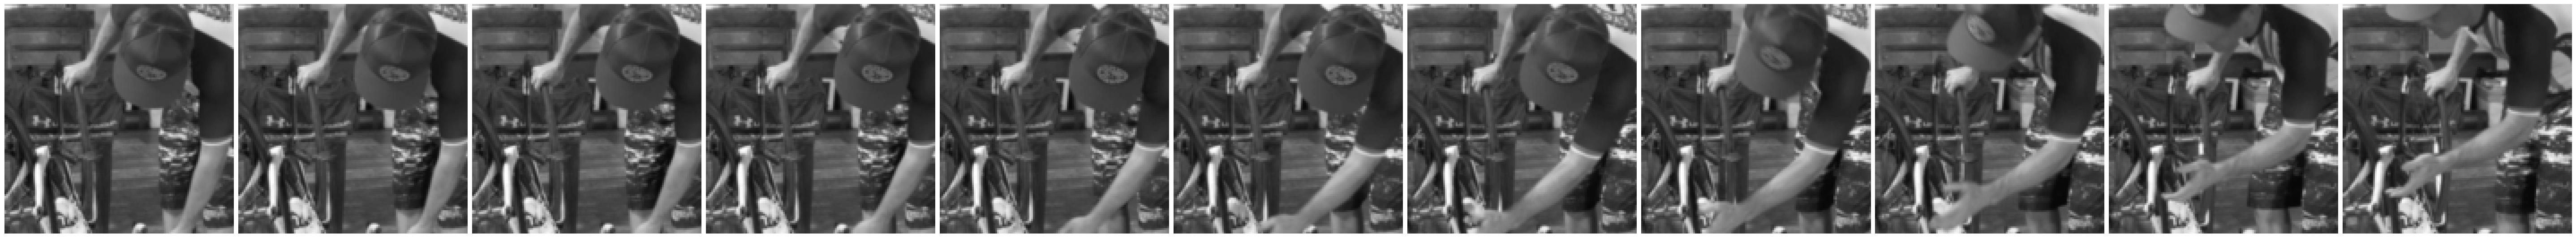

Temporal finite difference


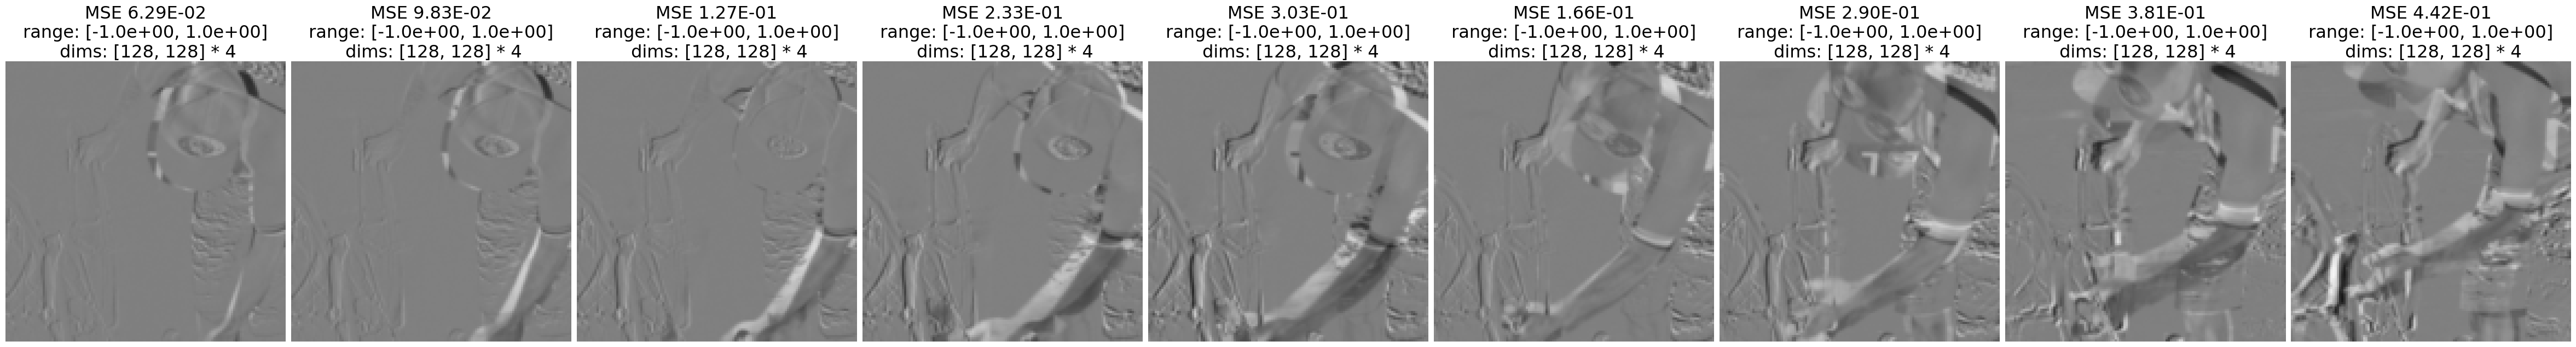

In [5]:
MSE = (x[:, :, 2:] - x[:, :, 1:-1]).pow(2).mean((1,3,4))
print(f'average MSE {MSE.mean():.2E}')

# visualize an example
j = 0
print('A video snippet from the training set')
from ppm.utils import undo_standardize
imshow(undo_standardize(x, data_stats)[j], zoom=4, vrange=vrange, title=None)
plt.show()

print('Temporal finite difference')
imshow(
    torch.diff(undo_standardize(x, data_stats), dim=2)[j, :, 1:],
    zoom=4, vrange=[-1, 1], title=[f"MSE {e:.2E}" for e in MSE[j]]
)
plt.show()

### Network

In [6]:
model = PolarPredictor(filter_size=17, num_channels=32).to(DEVICE)

### Training

In [7]:
model = train_model(model, train_dataloader, test_dataloader, num_epochs=10)

Val   epoch 10: 1.77E-01 MSE: 100%|██████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.02it/s]


## Visualization

### Example predictions

In [8]:
x = next(test_dataloader.__iter__()).to(DEVICE)
x_hat = model(x)
print(x.shape, x_hat.shape)
target, pred = model.crop(x, x_hat)
MSE = (target - pred).pow(2).mean((1, 3, 4))
print(target.shape, pred.shape, MSE.shape)
print(f'average MSE {MSE.mean():.2E}')

torch.Size([4, 1, 11, 128, 128]) torch.Size([4, 1, 9, 128, 128])
torch.Size([4, 1, 9, 94, 94]) torch.Size([4, 1, 9, 94, 94]) torch.Size([4, 9])
average MSE 1.83E-01


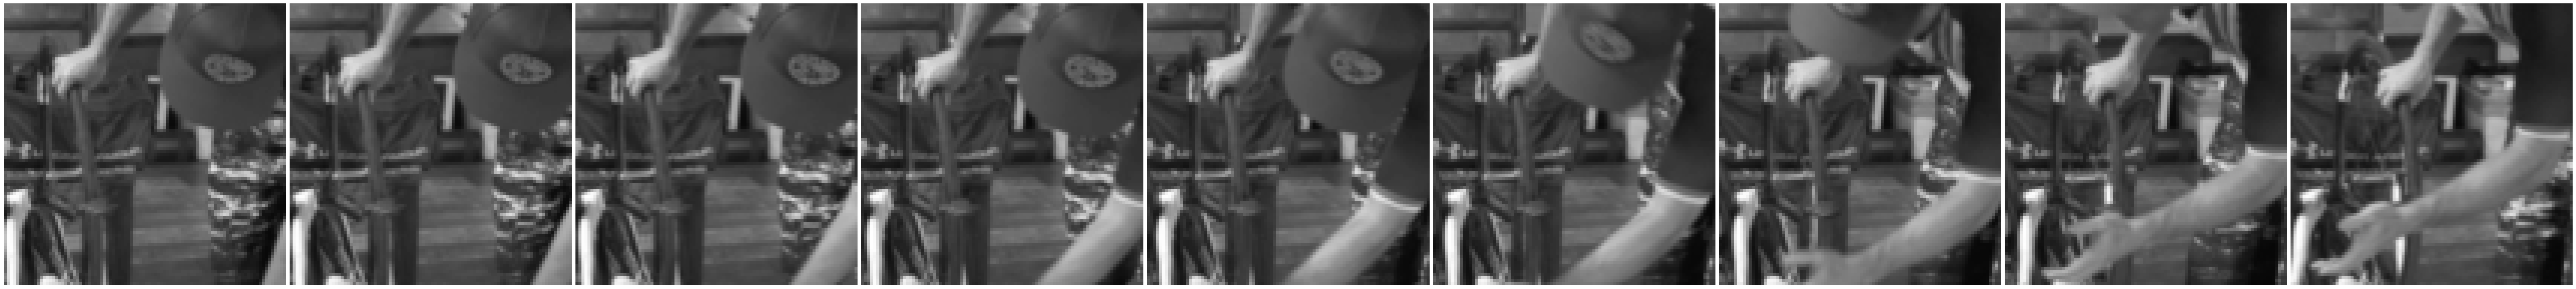

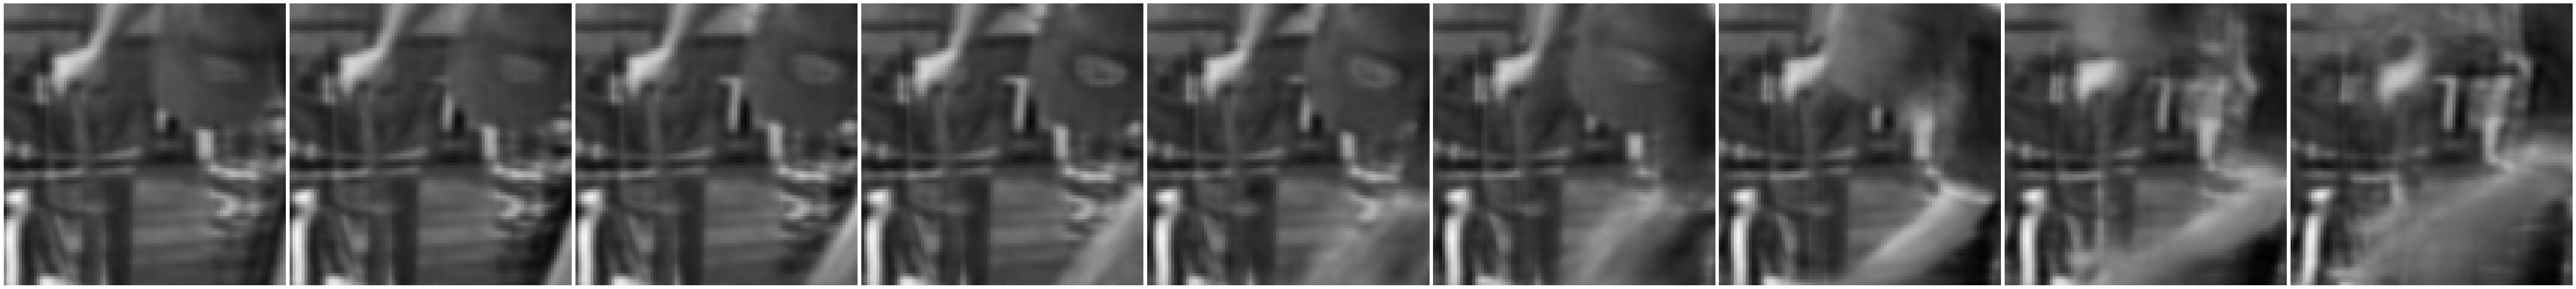

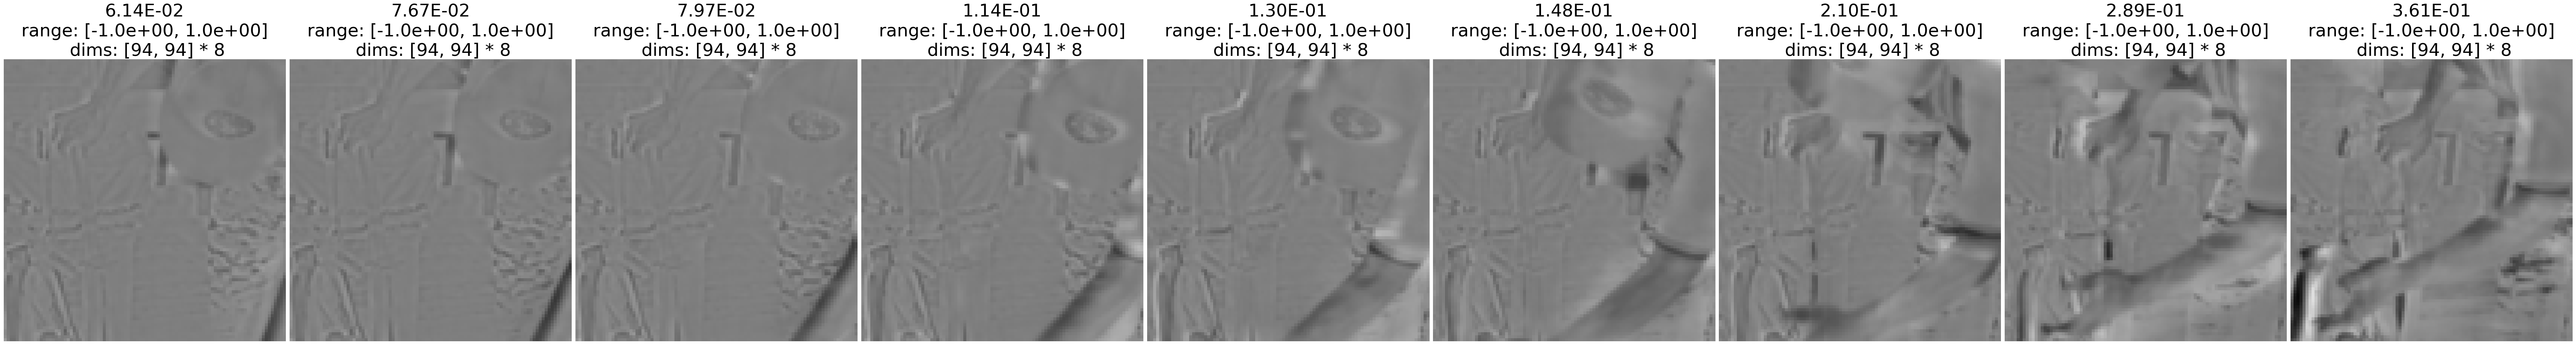

In [9]:
j = 0
imshow(
    undo_standardize(target, data_stats)[j],
    vrange=vrange, zoom=8, title=None
);
imshow(
    undo_standardize(pred, data_stats)[j],
    vrange=vrange, zoom=8, title=None
);
imshow(
    (undo_standardize(pred, data_stats) -
     undo_standardize(target, data_stats))[j],
    vrange=[-1, 1], zoom=8, title=[f"{e:.2E}" for e in MSE[j]]
);

### Weights

In [10]:
W = model.W.data.cpu()
W.shape

torch.Size([32, 1, 17, 17])

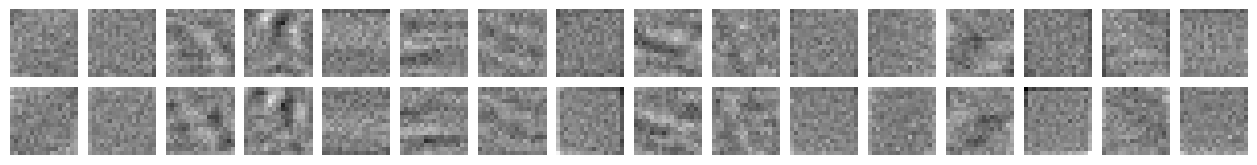

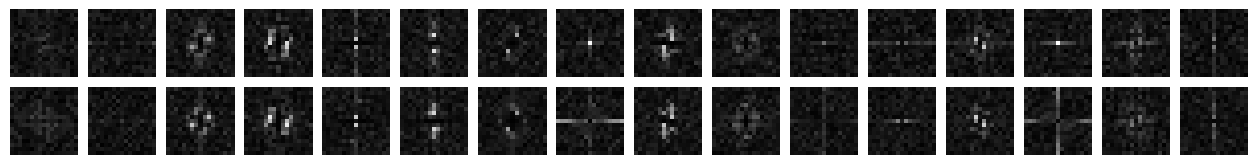

In [11]:
# each column displays a pair of filters
imshow(
    rearrange(W, '(c two) 1 h w -> (two c) 1 h w', two=2),
    col_wrap=len(W)//2, zoom=4, title=None, vrange='auto1'
);
W_tilde = torch.fft.fftshift(torch.fft.fft2(W, norm='ortho'), dim=(2, 3))
W_tilde_amp = torch.abs(W_tilde)
imshow(
    rearrange(W_tilde_amp, '(c two) 1 h w -> (two c) 1 h w', two=2),
    col_wrap=len(W)//2, zoom=4, title=None, vrange='auto1'
);

# note: this is a proof of principle, a more developed version is available at
# https://github.com/pehf/PolarPrediction